#Modelo autorregresivo integrado de media móvil (ARIMA)

Además de lo presentado anteriormente, quisimos complementar llevando a cabo un modelo ARIMA, enfocándonos únicamente en México y en las variables que nos pudieran dar resultados significativos, definitorios y útiles al momento de pronosticar el avance en diferentes aspectos de la pandemia. 

Es por ello que utilizamos el total de fallecimientos (total_deaths) y el total de casos (total_cases), puesto que contamos con números sobre esos datos desde febrero del 2020, lo cual nos permitió tener una base más sólida para entrenar a nuestro modelo, tomando en cuenta que el modelo ARIMA da como resultado una proyección basándose en un proceso estocástico.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid") # estilo de salida de las gráficas
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from datetime import datetime

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('/content/drive/My Drive/owid-covid-data.csv')

tipos_nuevos = {
    'continent': 'category',
    'location': 'category',
    'iso_code': 'category',
}

df = df.astype(tipos_nuevos)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


## Proyección sobre total de muertes por COVID-19

No tomamos los datos referentes al mes de noviembre, ya que nuestra proyección sería imprecisa, debido a que estamos haciendo nuestro análisis basándonos en el TOTAL de muertes al mes.

In [ ]:
# Trabajaremos única y exclusivamente con datos pertenecientes a México
df_mexico = df[df['location'] == 'Mexico']

df_mexico = df_mexico.dropna(subset=['total_deaths'])
df_mexico = df_mexico.reset_index(drop=True)

# Al index de cada uno de nuestros registros le asignamos el valor de 'date'.
# Tenemos la certeza de que estos valores no se repetirán. Necesario para usar resample más adelante
df_mexico.index = df_mexico.date

df_mexico.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-19,MEX,North America,Mexico,2020-03-19,164.0,46.0,21.714,1.0,1.0,0.143,1.259,0.353,0.167,0.008,0.008,0.001,1.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,840.0,16838.0,0.129,0.006,517.0,0.004,0.167,6.0,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,130262220.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN
2020-03-20,MEX,North America,Mexico,2020-03-20,203.0,39.0,25.286,2.0,1.0,0.286,1.558,0.299,0.194,0.015,0.008,0.002,1.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,758.0,17596.0,0.135,0.006,562.0,0.004,0.170,5.9,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,130262220.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN
2020-03-21,MEX,North America,Mexico,2020-03-21,251.0,48.0,30.000,2.0,0.0,0.286,1.927,0.368,0.230,0.015,0.000,0.002,1.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,495.0,18091.0,0.139,0.004,601.0,0.005,0.167,6.0,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,130262220.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN
2020-03-22,MEX,North America,Mexico,2020-03-22,316.0,65.0,37.571,3.0,1.0,0.429,2.426,0.499,0.288,0.023,0.008,0.003,1.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,415.0,18506.0,0.142,0.003,626.0,0.005,0.168,6.0,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,130262220.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,-9693.7,-5.13,-10.26,-74.416819
2020-03-23,MEX,North America,Mexico,2020-03-23,367.0,51.0,40.714,4.0,1.0,0.571,2.817,0.392,0.313,0.031,0.008,0.004,1.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1087.0,19593.0,0.150,0.008,729.0,0.006,0.162,6.2,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,130262220.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN


In [ ]:
# Agrupamos por cada uno de los meses, sumando el número de 'x' que hubo a lo largo el mismo
mexico_month_cases = pd.DataFrame(df_mexico.resample('m')['total_deaths'].sum())
mexico_month_cases

,total_deaths
date,
2020-03-31,136.0
2020-04-30,19390.0
2020-05-31,165485.0
2020-06-30,562682.0
2020-07-31,1164238.0
2020-08-31,1749213.0
2020-09-30,2150492.0
2020-10-31,2649132.0
2020-11-30,2962546.0


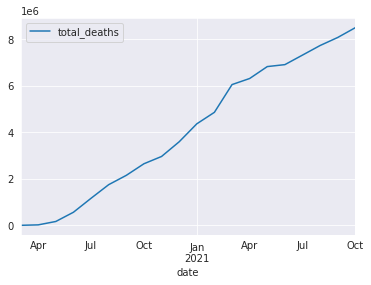

In [ ]:
mexico_month_cases.plot()
plt.show()

In [ ]:
# Dividiremos nuestros datos en dos:
# X_train -> subset que utilizaremos para entrenar a nuestro modelo. Son datos correspondientes del inicio de la emergencia sanitaria en nuestro país (marzo de 2020) a mayo del 2021
# X_valid -> subset que utilizaremos para validar los resultados de nuestro modelo y revisar que tan acertados son estos con respecto a los datos reales. 
#             Corresponden al lapso de mayo del 2021 a octubre del mismo año.
X_train = mexico_month_cases[mexico_month_cases.index < '2021-06-30']
X_valid = mexico_month_cases[mexico_month_cases.index >= '2021-05-31']

df_train = X_train.copy()
df_train['date'] = X_train.index
df_train = df_train.reset_index(drop=True)

print(f'Training: {X_train.shape} - Validation: {X_valid.shape}')

Training: (15, 1) - Validation: (6, 1)


In [ ]:
# Los datos que nos interesan saber corresponden al lapso de mayo del 2021 a febrero del 2022
meses_proyeccion = pd.date_range(X_train.index[-1], periods=10, freq='M')
meses_proyeccion

DatetimeIndex(['2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28'],
              dtype='datetime64[ns]', freq='M')

In [ ]:
# Buscando los mejores valores para nuestro modelo ARIMA
# AR para la componente autorregresiva, I para la integrada y MA para la media móvil.

# Iteraremos sobre algunas posibles combinaciones que podriamos usar en nuestro modelo
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

for param in pdq:
    try:
        arima = ARIMA(X_train,order=param)
        arima_fit = arima.fit()
        print(param, arima_fit.aic)
    except:
        pass
    
# El criterio de información de Akaike (AIC) es una medida de la calidad relativa de un modelo estadístico, para un conjunto dado de datos.

# Dado un conjunto de modelos candidatos para los datos, el modelo preferido es el que tiene el valor mínimo en el AIC. 
# Sin embargo, el modelo con el criterio AIC más pequeño para un conjunto de predictores no necesariamente ajusta los datos adecuadamente.

(0, 0, 0) 485.802021977291
(0, 0, 1) 472.90264071969887
(0, 0, 3) 457.1652930298544


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(0, 0, 4) 452.7791272912033
(0, 1, 0) 394.39118868117635
(0, 1, 1) 396.37518572923915
(0, 1, 2) 397.4982803272643


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(0, 1, 3) 397.6036791799847
(0, 1, 4) 398.47899788375213
(0, 2, 0) 374.3666136079685
(0, 2, 1) 368.3388084275782


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(0, 2, 3) 371.9343835598196
(1, 0, 0) 449.12104021137895
(1, 1, 0) 396.3689742525045


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)


(1, 1, 1) 398.0707217378442
(1, 1, 2) 397.91757395619516
(1, 1, 3) 398.3745430867875


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 1, 4) 411.0058268285821
(1, 2, 0) 370.61953717967555


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


(1, 2, 1) 370.08543029893997


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 2, 2) 390.00165589669433


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 2, 3) 373.87937202699555


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 2, 4) 374.5881893049452
(2, 0, 0) 438.01608264315814
(2, 1, 0) 397.7937679558404


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(2, 1, 1) 402.1558438775609
(2, 1, 2) 399.79963089874786


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(2, 1, 4) 401.7553360161665
(2, 2, 0) 372.14838023775087


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 0) 454.97277766369564
(3, 1, 0) 399.5576891299669


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:649: RuntimeWarning: invalid value encountered in double_scalars
  (1-a**2)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: divide by zero encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


(3, 1, 2) 400.3514972516236


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in arctanh
  invarcoefs = 2*np.arctanh(params)


(4, 0, 0) 458.3214942967061


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


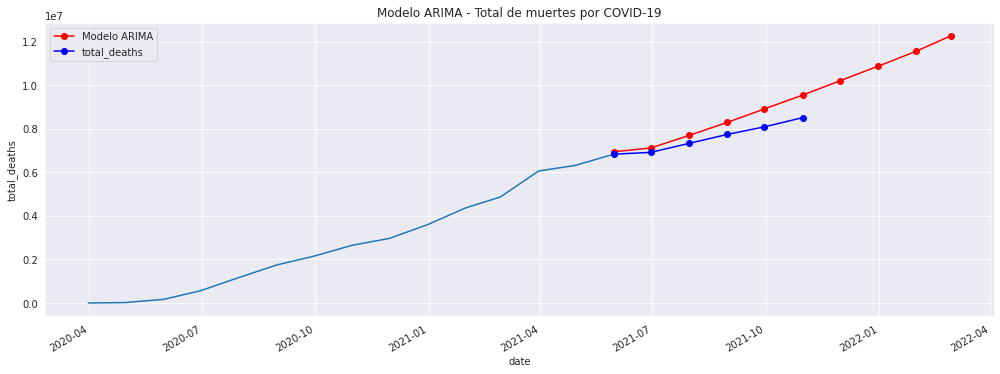

In [ ]:
arima = ARIMA(X_train, order=(0,2,3))
arima_fit = arima.fit()

proyeccion = arima_fit.forecast(10)[0]

proyeccion = pd.Series(proyeccion, index=meses_proyeccion)
proyeccion = proyeccion.rename("Modelo ARIMA") 

fig, ax = plt.subplots(figsize=(17,6))
chart = sns.lineplot(x='date', y='total_deaths', data=df_train)
chart.set_title('Modelo ARIMA - Total de muertes por COVID-19')
proyeccion.plot(ax=ax, color='red', marker="o", legend=True)
X_valid.plot(ax=ax, color='blue', marker="o", legend=True)

## Proyección sobre total de casos de COVID-19

In [ ]:
# Trabajaremos única y exclusivamente con datos pertenecientes a México
df_mexico = df[df['location'] == 'Mexico']

df_mexico = df_mexico.dropna(subset=['total_cases'])
df_mexico = df_mexico.reset_index(drop=True)

# Al index de cada uno de nuestros registros le asignamos el valor de 'date'.
# Tenemos la certeza de que estos valores no se repetirán. Necesario para usar resample más adelante
df_mexico.index = df_mexico.date

df_mexico

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-28,MEX,North America,Mexico,2020-02-28,1.0,1.0,NaN,NaN,NaN,NaN,0.008,0.008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216.0,10404.0,0.080,0.002,179.0,0.001,0.005,200.0,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,130262220.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN
2020-02-29,MEX,North America,Mexico,2020-02-29,4.0,3.0,NaN,NaN,NaN,NaN,0.031,0.023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.0,10488.0,0.081,0.001,184.0,0.001,0.006,166.7,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,130262220.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN
2020-03-01,MEX,North America,Mexico,2020-03-01,5.0,1.0,NaN,NaN,NaN,NaN,0.038,0.008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.0,10633.0,0.082,0.001,189.0,0.001,0.008,125.0,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,130262220.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,-6307.3,-4.35,-9.63,-48.420025
2020-03-02,MEX,North America,Mexico,2020-03-02,5.0,0.0,NaN,NaN,NaN,NaN,0.038,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,279.0,10912.0,0.084,0.002,198.0,0.002,0.011,90.9,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,130262220.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN
2020-03-03,MEX,North America,Mexico,2020-03-03,5.0,0.0,NaN,NaN,NaN,NaN,0.038,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,285.0,11197.0,0.086,0.002,201.0,0.002,0.017,58.8,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,130262220.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-26,MEX,North America,Mexico,2021-10-26,3784448.0,0.0,3108.429,286496.0,0.0,224.429,29052.537,0.000,23.863,2199.379,0.000,1.723,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15227.0,10748192.0,82.512,0.117,14778.0,0.113,0.190,5.3,people tested,118849796.0,71366205.0,55942853.0,NaN,1608947.0,836257.0,91.24,54.79,42.95,NaN,6420.0,NaN,130262220.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN
2021-10-27,MEX,North America,Mexico,2021-10-27,3788986.0,4538.0,3032.571,286

In [ ]:
# Agrupamos por cada uno de los meses, sumando el número de 'x' que hubo a lo largo el mismo
mexico_month_cases = pd.DataFrame(df_mexico.resample('m')['total_cases'].sum())
mexico_month_cases

,total_cases
date,
2020-02-29,5.0
2020-03-31,8124.0
2020-04-30,229514.0
2020-05-31,1560343.0
2020-06-30,4692440.0
2020-07-31,10107738.0
2020-08-31,16108026.0
2020-09-30,20309152.0
2020-10-31,26077771.0


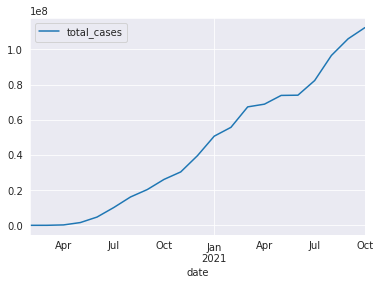

In [ ]:
mexico_month_cases.plot()
plt.show()

In [ ]:
# Dividiremos nuestros datos en dos:
# X_train -> subset que utilizaremos para entrenar a nuestro modelo. Son datos correspondientes del inicio de la emergencia sanitaria en nuestro país (marzo de 2020) a mayo del 2021
# X_valid -> subset que utilizaremos para validar los resultados de nuestro modelo y revisar que tan acertados son estos con respecto a los datos reales. 
#             Corresponden al lapso de mayo del 2021 a octubre del mismo año.
X_train = mexico_month_cases[mexico_month_cases.index < '2021-06-30']
X_valid = mexico_month_cases[mexico_month_cases.index >= '2021-05-31']

df_train = X_train.copy()
df_train['date'] = X_train.index
df_train = df_train.reset_index(drop=True)

print(f'Training: {X_train.shape} - Validation: {X_valid.shape}')

Training: (16, 1) - Validation: (6, 1)


In [ ]:
# Los datos que nos interesan saber corresponden al lapso de mayo del 2021 a febrero del 2022
meses_proyeccion = pd.date_range(X_train.index[-1], periods=10, freq='M')
meses_proyeccion

DatetimeIndex(['2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28'],
              dtype='datetime64[ns]', freq='M')

In [ ]:
# Buscando los mejores valores para nuestro modelo ARIMA
# AR para la componente autorregresiva, I para la integrada y MA para la media móvil.

# Iteraremos sobre algunas posibles combinaciones que podriamos usar en nuestro modelo
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

for param in pdq:
    try:
        arima = ARIMA(X_train,order=param)
        arima_fit = arima.fit()
        print(param, arima_fit.aic)
    except:
        pass
    
# El criterio de información de Akaike (AIC) es una medida de la calidad relativa de un modelo estadístico, para un conjunto dado de datos.

# Dado un conjunto de modelos candidatos para los datos, el modelo preferido es el que tiene el valor mínimo en el AIC. 
# Sin embargo, el modelo con el criterio AIC más pequeño para un conjunto de predictores no necesariamente ajusta los datos adecuadamente.

(0, 0, 0) 595.7622158591871
(0, 0, 1) 581.6039857152227
(0, 0, 3) 563.9955356306107
(0, 0, 4) 558.8463119322279
(0, 1, 0) 498.14720654474655
(0, 1, 1) 499.50079278191276
(0, 1, 2) 494.96744937552216
(0, 1, 3) 496.4252009408598
(0, 1, 4) 498.398268338662
(0, 2, 0) 470.2008293744713
(0, 2, 1) 465.8681762653164
(0, 2, 3) 465.1793026859021
(1, 0, 0) 554.3972657478357


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 1, 0) 499.00924363361935
(1, 2, 0) 465.2916666475555
(2, 0, 0) 543.0270983416227
(2, 1, 0) 498.6845189293849
(2, 2, 0) 467.2186883550645


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: Converge

(2, 2, 1) 494.9061819864133


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 0, 0) 554.8461050786998
(3, 1, 0) 500.46984933303463
(3, 2, 0) 468.3590136619549
(3, 2, 1) 495.21689547249775


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/s

(4, 0, 0) 557.2887692068177
(4, 1, 0) 499.51859437297037


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


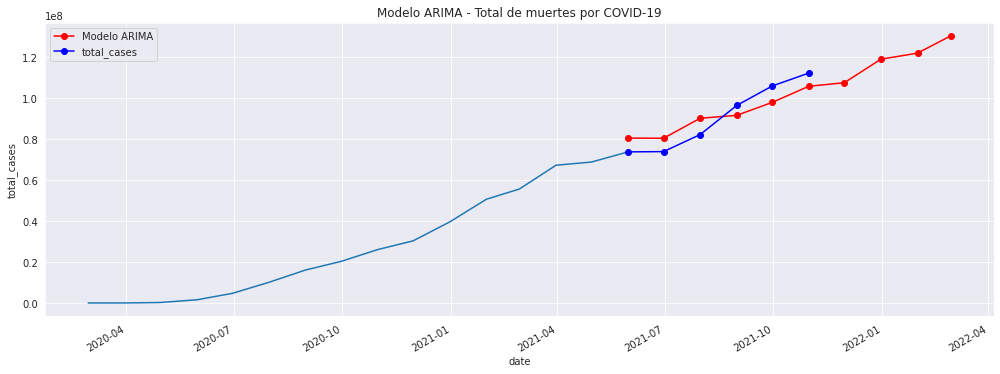

In [ ]:
arima = ARIMA(X_train, order=(3,2,1)) #023
arima_fit = arima.fit()

proyeccion = arima_fit.forecast(10)[0]

proyeccion = pd.Series(proyeccion, index=meses_proyeccion)
proyeccion = proyeccion.rename("Modelo ARIMA") 

fig, ax = plt.subplots(figsize=(17,6))
chart = sns.lineplot(x='date', y='total_cases', data=df_train)
chart.set_title('Modelo ARIMA - Total de muertes por COVID-19')
proyeccion.plot(ax=ax, color='red', marker="o", legend=True)
X_valid.plot(ax=ax, color='blue', marker="o", legend=True)